In [1]:
import category_encoders as ce
from collections import Counter
from geopy import distance
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import feature_selection
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from textblob import TextBlob
import time
import math


# Configuration parameters

In [2]:
KAGGLE_ENV = False
DEBUG = True
RANDOM_STATE = 18
TARGET_COLUMN_NAME = 'reviewer_score'
TEST_SIZE = 0.25

# cleanup
POST_CLEANUP_MASKS = None

# feature creation
BINARY_ENCODERS = None
ONEHOT_ENCODERS = None
TOP_TAGS_MAX_NUMBER = None
TOP_TAGS_LIST = None

# feature selection
CATEGORICAL_COLUMNS = None
CATEGORICAL_COLUMNS_BY_IMPORTANCE = None
CATEGORICAL_COLUMNS_NUM = None
NUMERIC_COLUMNS = None
NUMERIC_COLUMNS_BY_IMPORTANCE = None
NUMERIC_COLUMNS_NUM = None
TAGS_COUNTER = None

# feature transformation
COLUMNS_TO_STANDARDIZE = None
COLUMNS_TO_NORMALIZE = None
NORM_SCALER = None
STND_SCALER = None

# training
CHUNK_TO_TRAIN = None
EXCLUDE_COLUMNS = None
N_ESTIMATORS = None
MODEL = None


# Utility

## Common functions

In [3]:
def debug_print(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)

def describe_hist_box(data, column, log=False):
    """Receives a dataframe and a column name.
    Prints out this column statistics and renders its historgam and a box diagram.
    If `log` is True then will apply logarithmic scale to the diagrams.

    Args:
        data (pd.DataFrame): The dataframe.
        column (str): Name of the column to analyze.
        log (bool, optional): A flag to apply the logarithmi scale to diagrams. Defaults to False.
    """

    data=data[[column]]

    print(data.describe())

    fig, ax = figax(rowcol=(2, 1), name=column)

    sns.histplot(ax=ax[0], data=data, binwidth=1)
    sns.boxplot(ax=ax[1], data=data, orient='h')

    if log:
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')

def figax(figsize=(7, 4), rowcol=None, axes=[0,0,1,1], name='Foo'):
    """Creates a matplot figure and returns it and its axes.

    Args:
        figsize (tuple, optional): Figure. Defaults to (7, 4).
        rowcol (tuple, optional): How many rows and cols in the figure. Defaults to None.
        axes (list, optional): Rect [left, bottom, width, height] of the new axes. Defaults to [0,0,1,1].
        name (str, optional): Figure name. Defaults to 'Foo'.

    Returns:
        _type_: _description_
    """
    fig = plt.figure(name, figsize=figsize)
    
    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

def logger(fn):
    """A decorator which will measure how long a function has been executing.

    Args:
        fn (function): Function to log.
    """
    def decorated(*args, **kwargs):
        debug_print(f'>>> fn. `{fn.__name__}` is running')
        ts = time.time()
        res = fn(*args, **kwargs)
        te = time.time()
        delta = round((te-ts) * 1000)
        sec_mls = 'mls'
        if delta > 1000:
            delta = round(delta / 1000, 1)
            sec_mls = 's'
        debug_print(f'<<< fn. `{fn.__name__}` finished, took {delta} {sec_mls}\n')
        return res
    return decorated


## Data loading functions

In [4]:
if KAGGLE_ENV:
    train_data_orig = pd.read_csv('../input/sf-booking/hotels_train.csv')
    test_data_orig = pd.read_csv('../input/sf-booking/hotels_test.csv')
    submission_data_orig = pd.read_csv('../input/sf-booking/submission.csv')
else:
    train_data_orig = pd.read_csv('./data/input/hotels_train.csv.zip')
    test_data_orig = pd.read_csv('./data/input/hotels_test.csv.zip')
    submission_data_orig = pd.read_csv('./data/input/submission.csv.zip')

def get_train_data(chunk=None):
    if chunk is None:
        return train_data_orig.copy()
    return train_data_orig[0:chunk].copy()

def get_test_data(chunk=None):
    if chunk is None:
        return test_data_orig.copy()
    return test_data_orig[0:chunk].copy()

def get_submission_data():
    return submission_data_orig.copy()


## Data cleanup functions

In [5]:
@logger
def cleanup_data(data, is_train_set):
    if is_train_set:
        cleanup_data__remove_duplicates(data)

    if is_train_set:
        cleanup_data__remove_anomalies(data)

    cleanup_data__add_missing_coords(data)

    cleanup_data__remove_useless_features(data)

    if data.isna().sum().sum() > 0:
        raise ValueError('Data set still has nan after cleaning.')

@logger
def cleanup_data__remove_duplicates(data):
    m = data.duplicated()
    
    if m.sum() == 0:
        return

    data.drop_duplicates(inplace=True)
    debug_print(f'removed {str(m.sum())} duplicated rows')

@logger
def cleanup_data__remove_anomalies(data):
    pass

@logger
def cleanup_data__add_missing_coords(data):
    m1 = data['lat'].isna()
    m2 = data['lng'].isna()
    m = m1 | m2

    if m.sum() == 0:
        debug_print('There is no missing lat/lng')
        return

    # Lets try to populate missing lat/lng
    # we have stored some of them in addr_lat_lng.csv
    global KAGGLE_ENV
    if KAGGLE_ENV:
        addr_lat_lng_df = pd.read_csv('../input/hotel-lat-lng-by-address/address_lat_lng.csv')
    else:
        addr_lat_lng_df = pd.read_csv('./data/src/address_lat_lng.csv')

    def get_lat_lng(row):
        m = addr_lat_lng_df['hotel_address'] == row['hotel_address']
        if m.sum() == 1:
            lat, lng = addr_lat_lng_df[m][['lat', 'lng']].values[0]
            row['lat'] = lat
            row['lng'] = lng
        return row

    debug_print('Entries with missing lat/lng before: ' + str(data['lat'].isna().sum()))

    data.loc[m, ['lat', 'lng']] = data.apply(get_lat_lng, axis=1)

    debug_print('Entries with missing lat/lng after: ' + str(data['lat'].isna().sum()))

@logger
def cleanup_data__remove_useless_features(data):
    pass


## Feature creation functions

In [6]:
@logger
def create_features(data, is_train_set):
    global TAGS_COUNTER
    if is_train_set:
        TAGS_COUNTER = Counter()
    elif TAGS_COUNTER is None:
        raise ValueError('Counter `TAGS_COUNTER` is not defined. \
            Make sure to run `create_features` on train set first.')

    create_features__add_city(data)
    create_features__add_city_center_lat_lng(data)
    create_features__add_distance_to_city_center(data)
    create_features__add_time_features(data)
    create_features__add_review_polarity(data)
    create_features__recount_review_words(data)
    create_features__parse_days_since_review(data)
    create_features__parse_tags(data)
    create_features__add_tag_columns(data, is_train_set)
    create_features__apply_onehot(data, ['hotel_city', 'month', 'year'], 15, is_train_set);
    create_features__apply_binary(data, ['hotel_address', 'reviewer_nationality'], is_train_set);

@logger
def create_features__add_city(data):
    def get_city(addr):
        city_country = addr.split(' ')[-2:]
        if ' '.join(city_country) == 'United Kingdom':
            return 'London'
        return city_country[0]

    data.loc[:, 'hotel_city'] = data['hotel_address'].apply(get_city)
    debug_print(data['hotel_city'].value_counts())

@logger 
def create_features__add_city_center_lat_lng(data):
    data.loc[:, 'city_center_lat'] = data['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lat'])
    data.loc[:, 'city_center_lng'] = data['hotel_city'].apply(lambda x: get_city_lat_lng(x)['lng'])

@logger
def create_features__add_distance_to_city_center(data):
    def get_distance(cols):
        coord_1 = (cols['city_center_lat'], cols['city_center_lng'])
        coord_2 = (cols['lat'], cols['lng'])
        return round(distance.distance(coord_1, coord_2).km, 1)

    debug_print('setting `distance_to_city_center_km`')
    data.loc[:, 'distance_to_city_center_km'] = data.apply(get_distance, axis=1)
    data['distance_to_city_center_km'] = np.float16(data['distance_to_city_center_km'])

    debug_print('setting `is_center`')
    data.loc[:, 'is_center'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x < 1.5 else 0)
    data['is_center'] = np.int8(data['is_center'])

    debug_print('setting `is_walking_distance`')
    data.loc[:, 'is_walking_distance'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 1.5 and x < 3.0 else 0)
    data['is_walking_distance'] = np.int8(data['is_walking_distance'])

    debug_print('setting `is_not_far`')
    data.loc[:, 'is_not_far'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 3.0 and x < 6.0 else 0)
    data['is_not_far'] = np.int8(data['is_not_far'])

    debug_print('setting `is_far`')
    data.loc[:, 'is_far'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x >= 6.0 and x < 12.0 else 0)
    data['is_far'] = np.int8(data['is_far'])

    debug_print('setting `is_far_away`')
    data.loc[:, 'is_far_away'] = data['distance_to_city_center_km'].apply(lambda x: 1 if x > 12.0 else 0)
    data['is_far_away'] = np.int8(data['is_far_away'])

@logger
def create_features__add_review_polarity(data):
    get_polarity = lambda text: TextBlob(text).sentiment.polarity

    data.loc[:, 'negative_review_polarity'] = data['negative_review'].apply(get_polarity)
    data['negative_review_polarity'] = np.float16(data['negative_review_polarity'])

    data.loc[:, 'positive_review_polarity'] = data['positive_review'].apply(get_polarity)
    data['positive_review_polarity'] = np.float16(data['positive_review_polarity'])

@logger
def create_features__recount_review_words(data):
    count_words = lambda text: len([word for word in text.split(' ') if len(word) > 0])

    data.loc[:, 'review_total_negative_word_counts_alt'] = data['negative_review'].apply(count_words)
    data['review_total_negative_word_counts_alt'] = np.int16(data['review_total_negative_word_counts_alt'])

    data.loc[:, 'review_total_positive_word_counts_alt'] = data['positive_review'].apply(count_words)
    data['review_total_positive_word_counts_alt'] = np.int16(data['review_total_positive_word_counts_alt'])

@logger
def create_features__parse_days_since_review(data):
    data.loc[:, 'days_since_review_int'] = data['days_since_review'].apply(lambda x: int(x.split(' ')[0]))
    data['days_since_review_int'] = np.int16(data['days_since_review_int'])

@logger
def create_features__parse_tags(data):
    def analize_tags(tag_list_json_str):
        tag_list = json.loads(tag_list_json_str.replace('\'', '"'))
        tag_list = [tag.strip() for tag in tag_list]
        global TAGS_COUNTER
        TAGS_COUNTER.update(tag_list)
        tags_count = len(tag_list)

        return tags_count

    data.loc[:, 'tags_count'] = data['tags'].apply(analize_tags)
    data['tags_count'] = np.int16(data['tags_count'])

@logger
def create_features__add_tag_columns(data, is_train_set):
    global TOP_TAGS_MAX_NUMBER
    assert(type(TOP_TAGS_MAX_NUMBER) == int)

    global TOP_TAGS_LIST
    if is_train_set:
        TOP_TAGS_LIST = [t[0] for t in TAGS_COUNTER.most_common(TOP_TAGS_MAX_NUMBER)]
        # debug_print('top_100_tags')
        # debug_print(TOP_TAGS_LIST)

    tag_dict = {}

    def fn(top_tag):
        def fn2(tags):
            nonlocal tag_dict
            if tag_dict.get(tags) is None:
                tag_dict[tags] = [tag.strip() for tag in json.loads(tags.replace('\'', '"'))]
            return 1 if top_tag in tag_dict[tags] else 0
        return fn2

    tag_series = [pd.Series(data=data['tags'].apply(fn(top_tag)), name=top_tag) for top_tag in TOP_TAGS_LIST]

    result_columns = list(data.columns)
    result_columns.extend(TOP_TAGS_LIST)

    objs = [data]
    objs.extend(tag_series)

    data.loc[:, result_columns] = pd.concat(objs=objs, axis=1)

@logger
def create_features__add_time_features(data):
    data.loc[:, 'review_date_dt'] = pd.to_datetime(data['review_date'])
    data.loc[:, 'month'] = data['review_date_dt'].apply(lambda x: str(x.month))
    data.loc[:, 'year'] = data['review_date_dt'].apply(lambda x: str(x.year))
    data.loc[:, 'is_new_year'] = data['review_date_dt'].apply(lambda x: x.month == 1 and x.day <= 5)
    data.loc[:, 'is_xmas'] = data['review_date_dt'].apply(lambda x: x.month == 12 and x.day >= 25)

    data['is_new_year'] = np.int8(data['is_new_year'])
    data['is_xmas'] = np.int8(data['is_xmas'])

@logger
def create_features__apply_binary(data, features, is_train_set):
    global BINARY_ENCODERS

    if is_train_set:
        BINARY_ENCODERS = dict()
    else:
        assert(type(BINARY_ENCODERS) == dict)

    all_colunns = []

    for feature in features:
        # print(f'len(data[feature].unique()) = {len(data[feature].unique())}')
        if len(data[feature].unique()) > 2047:
            convert_rare_values_to_others(data, feature, how_many_to_keep=127)

        if BINARY_ENCODERS.get(feature) is None:
            BINARY_ENCODERS[feature] = ce.BinaryEncoder()
            BINARY_ENCODERS[feature].fit(data[feature])

        encoded_feature = BINARY_ENCODERS[feature].transform(data[feature])
        data.loc[:, encoded_feature.columns] = encoded_feature

        all_colunns.extend(encoded_feature.columns)

    for col in all_colunns:
        data[col] = np.int8(data[col])

@logger
def create_features__apply_onehot(data, features, onehot_max, is_train_set):
    global ONEHOT_ENCODERS

    if is_train_set:
        ONEHOT_ENCODERS = dict()
    else:
        assert(type(ONEHOT_ENCODERS) == dict)

    all_colunns = []

    for feature in features:
        if len(data[feature].unique()) > onehot_max:
            debug_print(f'"{feature}" unique values len id greater than onehot_max: {len(data[feature].unique())} > {onehot_max}')
            convert_rare_values_to_others(data, feature)
        
        if ONEHOT_ENCODERS.get(feature) is None:
            ONEHOT_ENCODERS[feature] = ce.OneHotEncoder()
            ONEHOT_ENCODERS[feature].fit(data[feature])

        encoded_feature = ONEHOT_ENCODERS[feature].transform(data[feature])

        data.loc[:, encoded_feature.columns] = encoded_feature

        all_colunns.extend(encoded_feature.columns)

    for col in all_colunns:
        data[col] = np.int8(data[col])

def convert_rare_values_to_others(data, feature='', how_many_to_keep=15):
    value_counts = data[feature].value_counts()

    difference_times = value_counts[0] / value_counts[how_many_to_keep]

    if difference_times < 100:
        debug_print(f'!! convert_rare_values_to_others for "{feature}"')
        debug_print(f'value_counts: {len(value_counts)}')
        debug_print(f'value_counts[0]: {value_counts[0]}')
        debug_print(f'value_counts[{how_many_to_keep}]: {value_counts[how_many_to_keep]}')
        debug_print(f'difference is {difference_times} times')

    allowed_values = value_counts.index[0: how_many_to_keep]
    data[feature] = data[feature].apply(lambda x: x if x in allowed_values else '-- others --')

concap = None
concap_dict = dict()
def get_city_lat_lng(city_name):
    global concap, concap_dict

    if concap is None:
        if KAGGLE_ENV:
            concap = pd.read_csv('../input/europe-cities-lat-lng/concap.csv')
        else:
            concap = pd.read_csv('./data/src/concap.csv')

    if concap_dict.get(city_name) is None:
        m = concap['CapitalName'] == city_name

        if m.sum() != 1:
            raise ValueError(f'Unable to find "{city_name}" in concap')

        city = concap[m]

        concap_dict[city_name] = {
            'lat': float(city['CapitalLatitude'].values[0]),
            'lng': float(city['CapitalLongitude'].values[0]),
        }

    return concap_dict[city_name]

## Feature selection functions

In [7]:
def get_selected_numeric_features():
    global NUMERIC_COLUMNS_BY_IMPORTANCE
    if NUMERIC_COLUMNS_BY_IMPORTANCE is not None:

        global NUMERIC_COLUMNS_NUM
        if type(NUMERIC_COLUMNS_NUM) == int:

            return NUMERIC_COLUMNS_BY_IMPORTANCE[0:NUMERIC_COLUMNS_NUM]
            
    return []

def get_selected_categorical_features():
    global CATEGORICAL_COLUMNS_BY_IMPORTANCE
    if CATEGORICAL_COLUMNS_BY_IMPORTANCE is not None:

        global CATEGORICAL_COLUMNS_NUM
        if type(CATEGORICAL_COLUMNS_NUM) == int:

            return CATEGORICAL_COLUMNS_BY_IMPORTANCE[0:CATEGORICAL_COLUMNS_NUM]
            
    return []
    SELECTED_NUMERIC_FEATURES = NUMERIC_COLUMNS_BY_IMPORTANCE[0:NUMERIC_COLUMNS_NUM]
    SELECTED_CATEGORICAL_FEATURES = CATEGORICAL_COLUMNS_BY_IMPORTANCE[0:CATEGORICAL_COLUMNS_NUM]

def get_selected_features():
    selected_features = []

    selected_features.extend(get_selected_numeric_features())
    selected_features.extend(get_selected_categorical_features())

    return selected_features

def visualize_correlation(data, annot=True, all=True):
    corr_data = data[get_selected_features()].corr()

    if all == False:
        to_drop = []
        for col in corr_data.columns:
            corr_data.loc[col, col] = 0
            min = corr_data[col].min()
            max = corr_data[col].max()
            if min > -0.7 and max < 0.7:
                to_drop.append(col)

        corr_data = data[get_selected_features()].drop(columns=to_drop).corr()

    size = round(math.log(len(corr_data.columns)) * 4)
    fig, ax = figax(figsize=(size, size), name='corr')
    sns.heatmap(ax=ax, data=corr_data, annot=annot)
    ax.set_title('Features correlation')
    plt.show()

def visualize_numeric_columns_importance(data, skip_diagram=False):
    global NUMERIC_COLUMNS
    assert(type(NUMERIC_COLUMNS) == list)

    global TARGET_COLUMN_NAME
    X = data.drop(columns=[TARGET_COLUMN_NAME])
    y = data[TARGET_COLUMN_NAME]

    num_cols = [col for col in NUMERIC_COLUMNS if col in list(X.columns)]

    f_classif_results = feature_selection.f_classif(X[num_cols], y)

    data = pd.DataFrame(data=f_classif_results[0], index=num_cols, columns=['value'])
    data.sort_values(by=['value'], inplace=True, ascending=False)

    if skip_diagram == False:
        fig, ax = figax(figsize=(7, 4), name='corr')
        sns.barplot(ax=ax, data=data, x='value', y=data.index)
        ax.set_title('Importance of numeric features')

    return list(data.index)

def get_numeric_columns_by_importance(data):
    return visualize_numeric_columns_importance(data, skip_diagram=True)

def visualize_categorical_columns_importance(data, skip_diagram=False):
    global CATEGORICAL_COLUMNS
    assert(type(CATEGORICAL_COLUMNS) == list)

    global TARGET_COLUMN_NAME
    X = data.drop(columns=[TARGET_COLUMN_NAME])
    y = data[TARGET_COLUMN_NAME]

    cat_cols = [col for col in CATEGORICAL_COLUMNS if col in list(X.columns)]

    chi2_results = feature_selection.chi2(X[cat_cols], y.astype('int'))

    data = pd.DataFrame(data=chi2_results[0], index=cat_cols, columns=['value'])
    data.sort_values(by=['value'], ascending=False, inplace=True)

    if skip_diagram == False:
        fig, ax = figax(figsize=(7, 25), name='corr')
        sns.barplot(ax=ax, data=data, x='value', y=data.index)
        ax.set_title('Importance of categorical features')

    return list(data.index)

def get_categorical_columns_by_importance(data):
    return visualize_categorical_columns_importance(data, skip_diagram=True)


## Transformation functions

In [8]:
@logger
def transform_features(data, is_train_set):
    transform_features__post_cleanup(data, is_train_set)
    transform_features__standardize_features(data, is_train_set)
    transform_features__normalize_features(data, is_train_set)

@logger
def transform_features__post_cleanup(data, is_train_set):
    global POST_CLEANUP_MASKS
    if POST_CLEANUP_MASKS is None:
        return

    if is_train_set:
        for m_lambda in POST_CLEANUP_MASKS:
            if m_lambda is not None:
                m = m_lambda(data)
                percent = round(m.sum() * 100.0 / data.shape[0], 1)
                data.drop(index=data[m].index, inplace=True)
                debug_print(f'Removed {m.sum()} rows ({percent}%)')

@logger
def transform_features__standardize_features(data, is_train_set):
    global COLUMNS_TO_STANDARDIZE
    assert(type(COLUMNS_TO_STANDARDIZE) == list)

    if len(COLUMNS_TO_STANDARDIZE) == 0:
        return

    global STND_SCALER
    if is_train_set:
        STND_SCALER = preprocessing.StandardScaler().fit(data[COLUMNS_TO_STANDARDIZE])

    ndarr = STND_SCALER.transform(data[COLUMNS_TO_STANDARDIZE])
    stnd_df = pd.DataFrame(ndarr, columns=[COLUMNS_TO_STANDARDIZE]).set_index(data.index)
    data.loc[:, COLUMNS_TO_STANDARDIZE] = stnd_df[COLUMNS_TO_STANDARDIZE]

@logger
def transform_features__normalize_features(data, is_train_set):
    global COLUMNS_TO_NORMALIZE
    assert(type(COLUMNS_TO_NORMALIZE) == list)

    if len(COLUMNS_TO_NORMALIZE) == 0:
        return

    global NORM_SCALER
    if is_train_set:
        NORM_SCALER = preprocessing.MinMaxScaler().fit(data[COLUMNS_TO_NORMALIZE])

    ndarr = NORM_SCALER.transform(data[COLUMNS_TO_NORMALIZE])
    norm_df = pd.DataFrame(ndarr, columns=[COLUMNS_TO_NORMALIZE]).set_index(data.index)
    data.loc[:, COLUMNS_TO_NORMALIZE] = norm_df[COLUMNS_TO_NORMALIZE]


## Training functions

In [9]:
def get_training_features():
    selected_features = get_selected_features()

    global EXCLUDE_COLUMNS
    if type(EXCLUDE_COLUMNS) == list:
        for col in EXCLUDE_COLUMNS:
            if col in selected_features:
                selected_features.remove(col)
    
    return selected_features

@logger
def split_to_train_test(data):
    X = data.copy()

    global TARGET_COLUMN_NAME
    y = data[TARGET_COLUMN_NAME]

    global TEST_SIZE
    global RANDOM_STATE
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    return X_train, X_test, y_train, y_test

@logger
def train_model(X_train, y_train):
    global N_ESTIMATORS
    assert(N_ESTIMATORS is not None)

    global RANDOM_STATE
    assert(RANDOM_STATE is not None)

    global TARGET_COLUMN_NAME
    if TARGET_COLUMN_NAME in list(X_train.columns):
        X_train = X_train.drop(columns=[TARGET_COLUMN_NAME])

    global MODEL
    MODEL = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

    if len(get_training_features()) > 0:
        X_train = X_train[get_training_features()]
    else:
        X_train = X_train.select_dtypes(include=[np.number])

    MODEL.fit(X_train, y_train)


MAPE = None

@logger
def estimate_model(X_test, y_test):
    global MODEL
    y_pred = predict(X_test)

    global MAPE
    MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
    # print('MAPE:', round(MAPE, 4))

    return y_pred, MAPE

@logger
def train_and_estimate(data):
    X_train, X_test, y_train, y_test = split_to_train_test(data)

    train_model(X_train, y_train)

    return estimate_model(X_test, y_test)

@logger
def predict(X_test):
    if len(get_training_features()) > 0:
        X_test = X_test[get_training_features()]
    else:
        X_test = X_test.select_dtypes(include=[np.number])

    y_pred = MODEL.predict(X_test)

    return y_pred


# First submission (simple model)

Lets train on the numeric data we have and make a prediction on it.

In [10]:
train_data = get_train_data()

X_train = train_data.copy()
X_train = X_train.drop(columns=[TARGET_COLUMN_NAME])
X_train.fillna(0, inplace=True)
N_ESTIMATORS = 100
y_train = train_data[TARGET_COLUMN_NAME]

train_model(X_train, y_train)

>>> fn. `train_model` is running
<<< fn. `train_model` finished, took 125.0 s



In [11]:
test_data = get_test_data()

X_test = test_data.select_dtypes(include=[np.number])


In [12]:
X_test.fillna(0, inplace=True)

y_pred = predict(X_test)

>>> fn. `predict` is running
<<< fn. `predict` finished, took 5.2 s



In [13]:
submission = get_submission_data()
submission[TARGET_COLUMN_NAME] = y_pred
if KAGGLE_ENV:
    submission.to_csv('hotels_prediction_1.csv', index = False)
else:
    submission.to_csv('./data/output/hotels_prediction_1.csv', index = False)


The result is **14.18270**. Now lets try to improve it.

## Creating a featured model

## Train dataset loading

Start by loading the train set. We will only do do the first training on a small part of the whole training set.

In [14]:
CHUNK_TO_TRAIN = 30_000
train_data = get_train_data(CHUNK_TO_TRAIN)

## Train dataset cleaning

First thing to do the train set is to run `cleanup_data`. During the cleanup we will not remove any useless feature. All the features will remain in the dataframe, however we will select only the important ones for the training later.

In [15]:
cleanup_data(train_data, is_train_set=True)

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 1 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 91 mls

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 171
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 3.0 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 3.1 s



## Creating features

We need to define some constants before running `create_features` function. They will be used in:
- `create_features__add_review_polarity`
- `create_features__add_tag_columns`

In [16]:
TOP_TAGS_MAX_NUMBER = 100

create_features(train_data, is_train_set=True)

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       15288
Barcelona     3481
Amsterdam     3445
Paris         3427
Vienna        2237
Milan         2121
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 21 mls

>>> fn. `create_features__add_city_center_lat_lng` is running
<<< fn. `create_features__add_city_center_lat_lng` finished, took 20 mls

>>> fn. `create_features__add_distance_to_city_center` is running
setting `distance_to_city_center_km`
setting `is_center`
setting `is_walking_distance`
setting `is_not_far`
setting `is_far`
setting `is_far_away`
<<< fn. `create_features__add_distance_to_city_center` finished, took 4.0 s

>>> fn. `create_features__add_time_features` is running
<<< fn. `create_features__add_time_features` finished, took 155 mls

>>> fn. `create_features__add_review_polarity` is running
<<< fn. `create_features__add_review_polarity` finished, took 6.5 s

>>> fn. `create_features__recount_

## Features selection

Time to check feature importance. To render numeric columns importants we need to list them in `NUMERIC_COLUMNS`

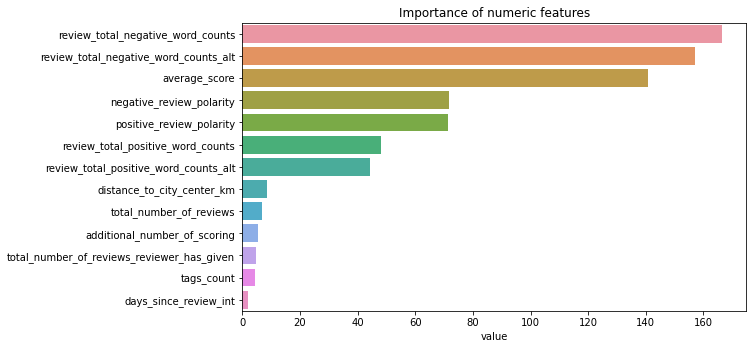

In [17]:
NUMERIC_COLUMNS = [
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'distance_to_city_center_km',
    'days_since_review_int',
    'negative_review_polarity',
    'positive_review_polarity',
    'review_total_negative_word_counts_alt',
    'review_total_positive_word_counts_alt',
    'tags_count',
]

NUMERIC_COLUMNS_BY_IMPORTANCE = visualize_numeric_columns_importance(train_data)

Now we can start to select features that will be used for training. Lets take 10 most important numeric columns.

In [18]:
NUMERIC_COLUMNS_NUM = 10

Before running `visualize_categorical_columns_importance` we need define the list of categorical columns and assign it to `CATEGORICAL_COLUMNS`.

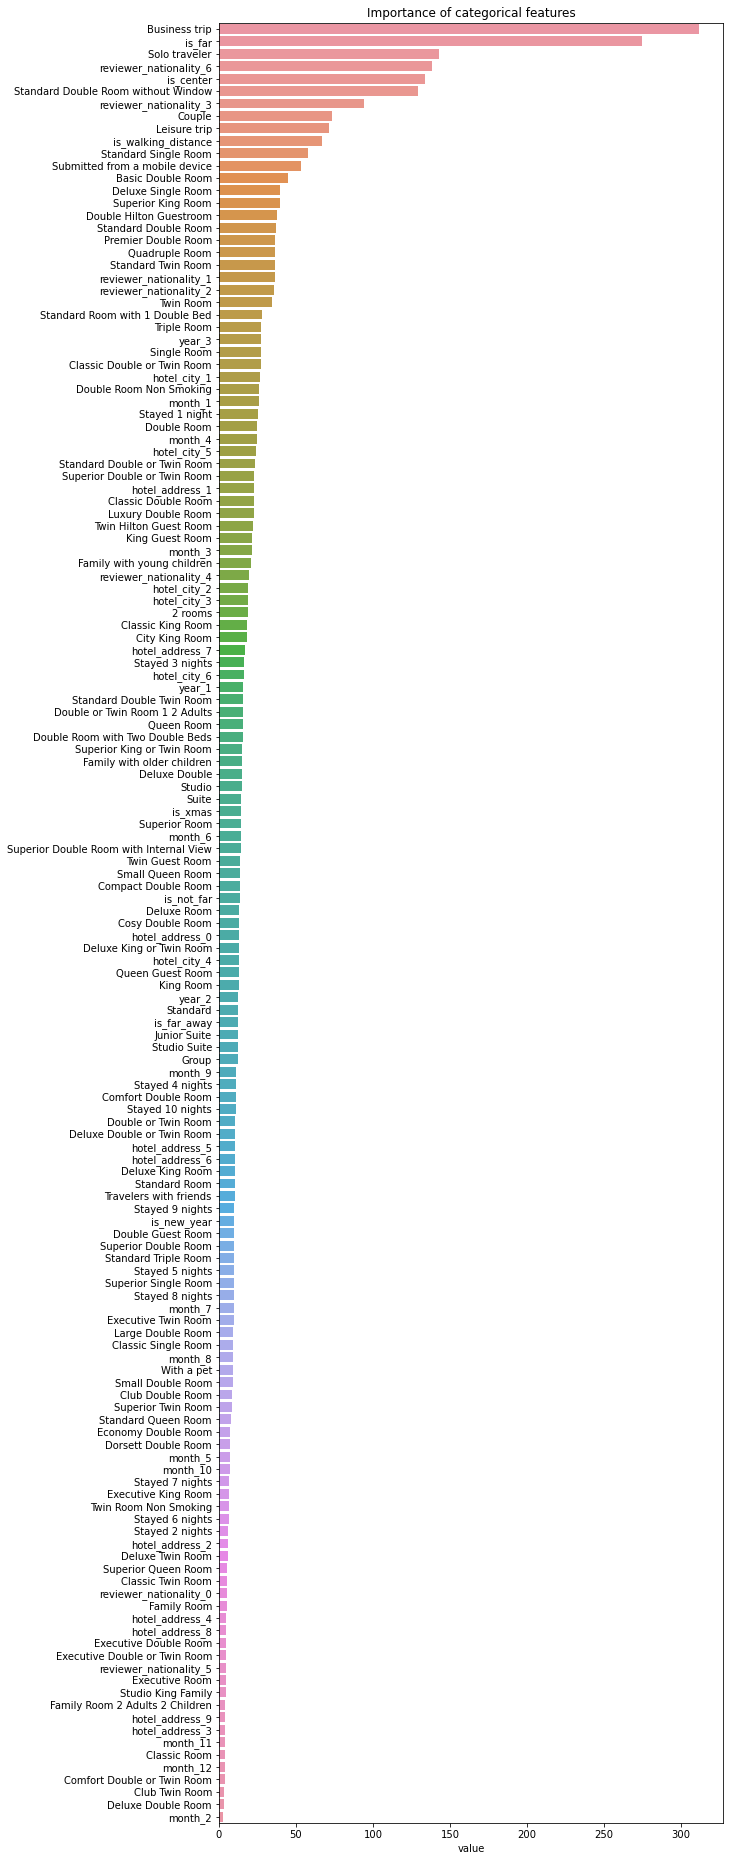

In [19]:
CATEGORICAL_COLUMNS = TOP_TAGS_LIST.copy()

CATEGORICAL_COLUMNS.extend([
    'is_center',
    'is_walking_distance',
    'is_not_far',
    'is_far',
    'is_far_away',
    'is_new_year',
    'is_xmas',
    'hotel_city_1',
    'hotel_city_2',
    'hotel_city_3',
    'hotel_city_4',
    'hotel_city_5',
    'hotel_city_6',
    'month_1',
    'month_2',
    'month_3',
    'month_4',
    'month_5',
    'month_6',
    'month_7',
    'month_8',
    'month_9',
    'month_10',
    'month_11',
    'month_12',
    'year_1',
    'year_2',
    'year_3',
    'hotel_address_0',
    'hotel_address_1',
    'hotel_address_2',
    'hotel_address_3',
    'hotel_address_4',
    'hotel_address_5',
    'hotel_address_6',
    'hotel_address_7',
    'hotel_address_8',
    'hotel_address_9',
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6'
])

CATEGORICAL_COLUMNS_BY_IMPORTANCE = visualize_categorical_columns_importance(train_data)

Let's continue selecting features for model training and add a small part of categorical columns.

In [20]:
CATEGORICAL_COLUMNS_NUM = 30

Lets render correlation heatmap to see if there is any multicollinearity.

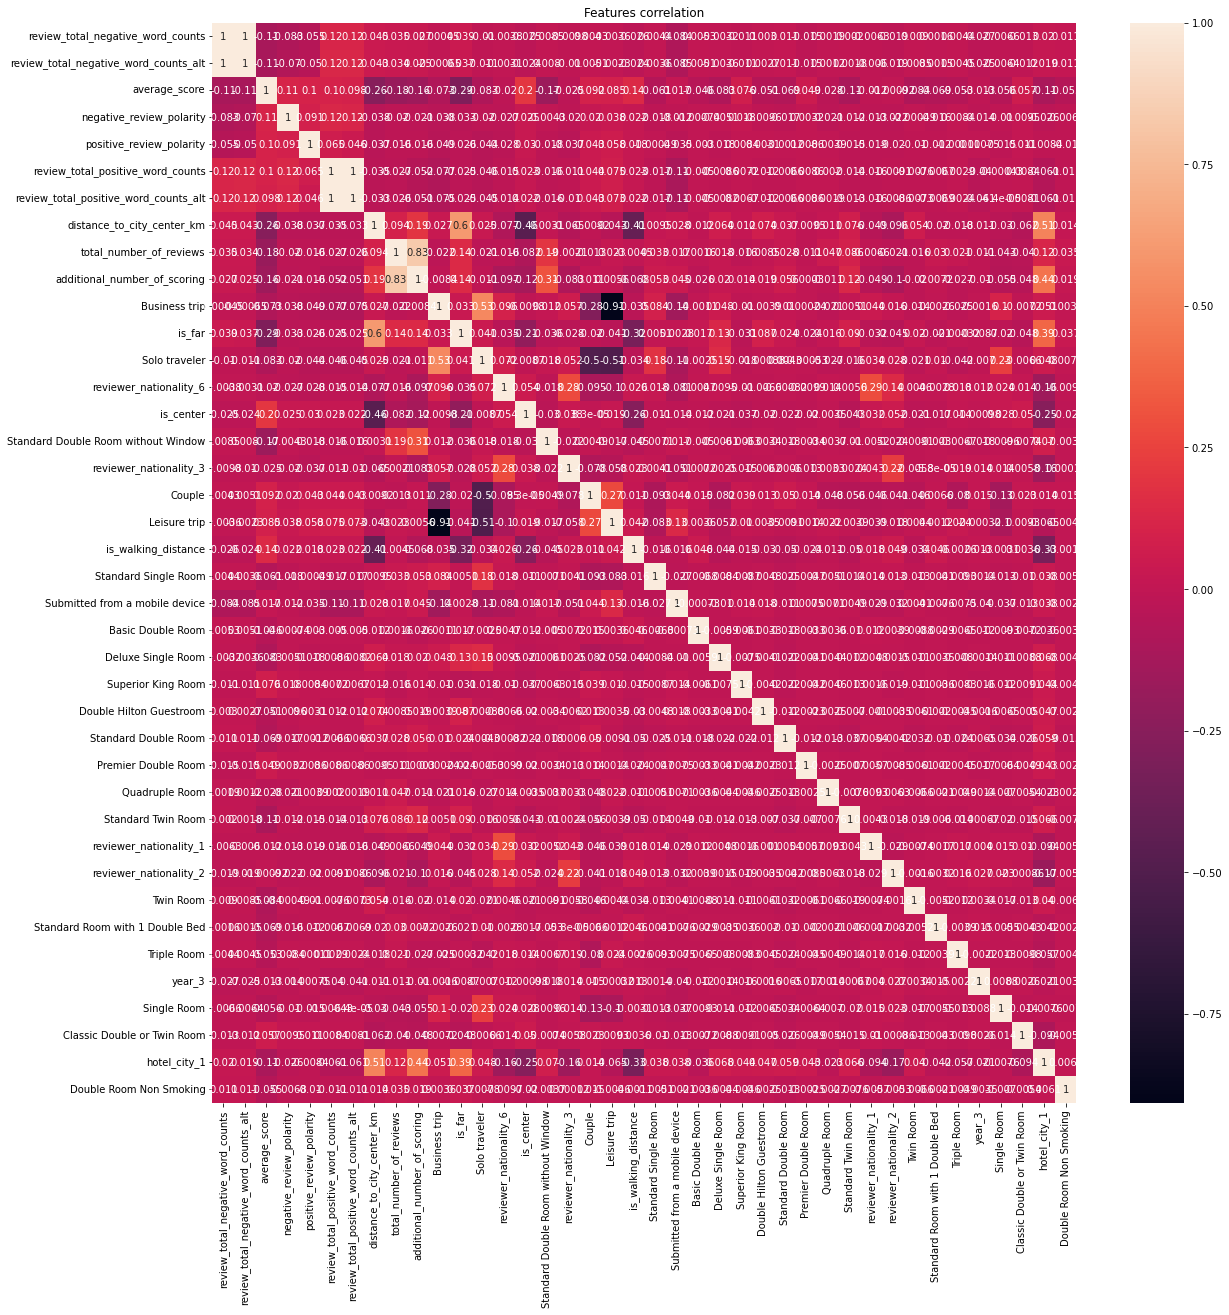

In [21]:
visualize_correlation(train_data)

It shows us that there are three pairs of features with high correlations:
1. `review_total_negative_word_counts` with `review_total_negative_word_counts_alt`
2. `review_total_positive_word_counts` with `review_total_positive_word_counts_alt`
3. `total_number_of_reviews` with `additional_number_of_scoring`

Lets exclude `review_total_negative_word_counts`, `review_total_positive_word_counts` and `additional_number_of_scoring`. All we need is to add them into `EXCLUDE_COLUMNS`


In [22]:
EXCLUDE_COLUMNS = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'additional_number_of_scoring',
]

## Data transformation

The last thing we need to do before training is feature transformation. Before doing that we will need to define `COLUMNS_TO_STANDARDIZE` and `COLUMNS_TO_NORMALIZE`. Lets visualize numeric columns distribution.

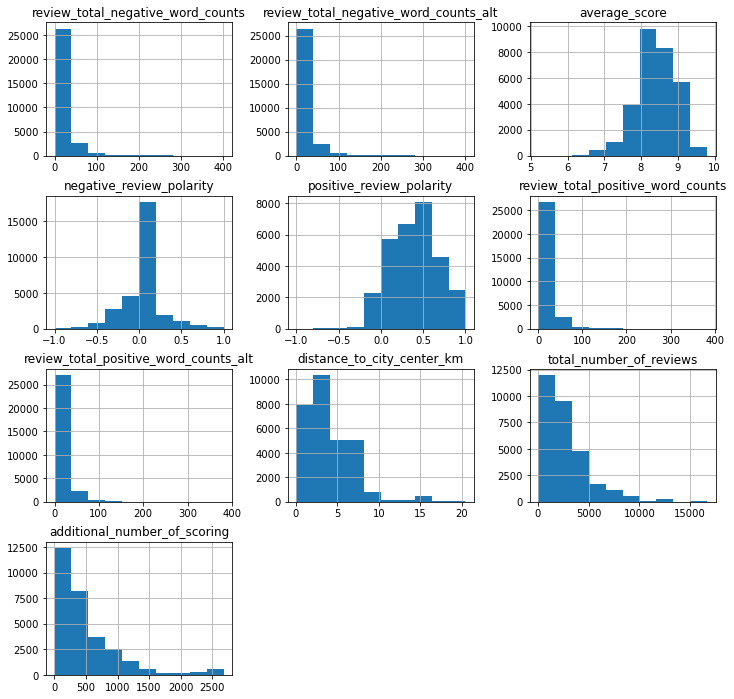

In [23]:
numeric_columns = get_selected_numeric_features()
train_data[numeric_columns].hist(figsize=(12, 12));

It seems `average_score`, `positive_review_polarity` and `negative_review_polarity` are normally distributed. Now we can split the columns into two groups and run `transform_features`

In [24]:
COLUMNS_TO_STANDARDIZE = [
    'average_score', 
    'positive_review_polarity',
    'negative_review_polarity',
]

COLUMNS_TO_NORMALIZE = get_selected_numeric_features()

for col in COLUMNS_TO_STANDARDIZE:
    COLUMNS_TO_NORMALIZE.remove(col)

train_data_before_transform = train_data.copy()
transform_features(train_data, is_train_set=True)

>>> fn. `transform_features` is running
>>> fn. `transform_features__post_cleanup` is running
<<< fn. `transform_features__post_cleanup` finished, took 0 mls

>>> fn. `transform_features__standardize_features` is running
<<< fn. `transform_features__standardize_features` finished, took 6 mls

>>> fn. `transform_features__normalize_features` is running
<<< fn. `transform_features__normalize_features` finished, took 15 mls

<<< fn. `transform_features` finished, took 22 mls



## Training and estimating

In [25]:
y_pred, mape = train_and_estimate(train_data)
print(f'MAPE: {mape}')

>>> fn. `train_and_estimate` is running
>>> fn. `split_to_train_test` is running
<<< fn. `split_to_train_test` finished, took 30 mls

>>> fn. `train_model` is running
<<< fn. `train_model` finished, took 9.7 s

>>> fn. `estimate_model` is running
>>> fn. `predict` is running
<<< fn. `predict` finished, took 139 mls

<<< fn. `estimate_model` finished, took 140 mls

<<< fn. `train_and_estimate` finished, took 9.9 s

MAPE: 0.12955296165868468


The model trained on a chunk of 30K rows shows an improvement. Lets train the model on whole data and submit second prediction.

# Second submission (featured model)

In [26]:
train_data = get_train_data()
cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)

train_data_before_transform = train_data.copy()

transform_features(train_data, is_train_set=True)
y_pred, mape = train_and_estimate(train_data)

print(f'MAPE of model trained on the whole train set: {mape}')

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 307 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 1.1 s

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 2448
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 36.2 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 37.6 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 243 mls

>>> fn. `create_features__add_city_c

In [27]:
test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
transform_features(test_data, is_train_set=False)
y_pred = predict(test_data)

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 820
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 12.6 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 12.7 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       65527
Paris        15098
Barcelona    15017
Amsterdam    14208
Vienna        9761
Milan         9324
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 83 mls

>>> fn. `create_features__add_city_center_lat_lng` is running
<<< fn. `create_features__add_city_center_lat_lng` finished, took 64 mls

>>> fn. `create_features__add_distance_to_city_center` is running
setting `distance_to_city_center_km`
setting `is_center`
setting `is_walking_distance`
setting `is_not

In [28]:
submission = get_submission_data()
submission[TARGET_COLUMN_NAME] = y_pred
if KAGGLE_ENV:
    submission.to_csv('hotels_prediction_2.csv', index = False)
else:
    submission.to_csv('./data/output/hotels_prediction_2.csv', index = False)



The result is **13.04826**.

Lets try to improve the result with some additional techniques.

# Improving the model: Excluding extremes

Let's try to exclude extreme values out from out train set. For that we need to create featured model and then investigate the extreme values in numeric columns.

## Making featured dataset

## Function to test extremes

We need a function which receives a dataset and then:
- splits it into train and test parts
- removes extreme values (by mask provided) from test part
- trains a model
- estimates the model with test part (where the mask was not used)

In [29]:
def test_extremes(data, masks_to_try):
    global DEBUG
    DEBUG = False

    for i, m_lambda in enumerate(masks_to_try):
        X = data.copy()
        global TARGET_COLUMN_NAME
        y = data[TARGET_COLUMN_NAME]

        train_data, test_data, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        train_data[TARGET_COLUMN_NAME] = y_train
        test_data[TARGET_COLUMN_NAME] = y_test

        m = m_lambda(train_data)
        train_data.drop(index=train_data[m].index, inplace=True)

        X_train = train_data.drop(columns=[TARGET_COLUMN_NAME])
        y_train = train_data[TARGET_COLUMN_NAME]
        train_model(X_train, y_train)

        X_test = test_data.drop(columns=[TARGET_COLUMN_NAME])
        y_test = test_data[TARGET_COLUMN_NAME]
        y_pred, mape = estimate_model(X_test, y_test)
        print(f'MAPE for mask {i} is {round(mape, 4)}')


## Base MAPE

We will test extremes on a part of the whole train set. Lets calculate the base MAPE which we will try to improve.

In [30]:
train_data = train_data_before_transform[0:100_000].copy()

y_pred, mape = train_and_estimate(train_data)

print(f'Base MAPE that needs to be improved: {mape}')

>>> fn. `train_and_estimate` is running
>>> fn. `split_to_train_test` is running
<<< fn. `split_to_train_test` finished, took 149 mls

>>> fn. `train_model` is running
<<< fn. `train_model` finished, took 35.3 s

>>> fn. `estimate_model` is running
>>> fn. `predict` is running
<<< fn. `predict` finished, took 625 mls

<<< fn. `estimate_model` finished, took 627 mls

<<< fn. `train_and_estimate` finished, took 36.1 s

Base MAPE that needs to be improved: 0.13116902952086507


## Features to analyze

In [31]:
for col in get_selected_numeric_features():
    if col in get_training_features():
        print(col)

review_total_negative_word_counts_alt
average_score
negative_review_polarity
positive_review_polarity
review_total_positive_word_counts_alt
distance_to_city_center_km
total_number_of_reviews


### Analyzing<br>`review_total_negative_word_counts_alt`

       review_total_negative_word_counts_alt
count                          100000.000000
mean                               17.807390
std                                29.065983
min                                 0.000000
25%                                 2.000000
50%                                 7.000000
75%                                22.000000
max                               406.000000


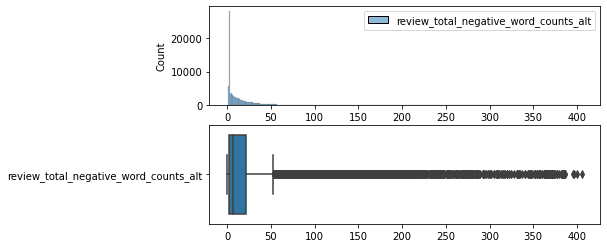

In [32]:
describe_hist_box(train_data, 'review_total_negative_word_counts_alt')

In [33]:
masks_to_try = [
    lambda x: x['review_total_negative_word_counts_alt'] > 150,
    lambda x: x['review_total_negative_word_counts_alt'] > 250,
    lambda x: x['review_total_negative_word_counts_alt'] > 350,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1315
MAPE for mask 1 is 0.1313
MAPE for mask 2 is 0.1312


### Analyzing<br>`average_score`

       average_score
count  100000.000000
mean        8.398129
std         0.547636
min         5.200000
25%         8.100000
50%         8.400000
75%         8.800000
max         9.800000


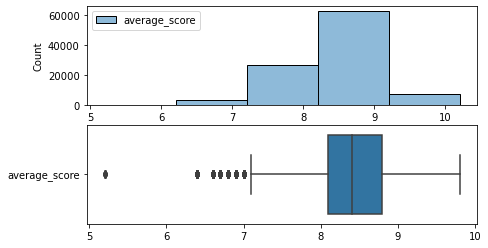

In [34]:
describe_hist_box(train_data, 'average_score')

In [35]:
masks_to_try = [
    lambda x: x['average_score'] < 5.5,
    lambda x: x['average_score'] < 6,
    lambda x: x['average_score'] < 6.5,
    lambda x: x['average_score'] < 7,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.131
MAPE for mask 1 is 0.131
MAPE for mask 2 is 0.131
MAPE for mask 3 is 0.1316


### Analyzing<br>`negative_review_polarity`

       negative_review_polarity
count             100000.000000
mean                   0.033173
std                    0.239624
min                   -1.000000
25%                   -0.050636
50%                    0.000000
75%                    0.150024
max                    1.000000


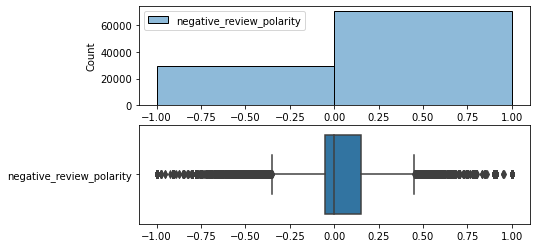

In [36]:
describe_hist_box(train_data, 'negative_review_polarity')

In [37]:
masks_to_try = [
    lambda x: x['negative_review_polarity'] < -0.95,
    lambda x: x['negative_review_polarity'] < -0.85,
    lambda x: x['negative_review_polarity'] < -0.75,
    lambda x: x['negative_review_polarity'] > 0.75,
    lambda x: x['negative_review_polarity'] > 0.85,
    lambda x: x['negative_review_polarity'] > 0.95,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1312
MAPE for mask 1 is 0.1311
MAPE for mask 2 is 0.131
MAPE for mask 3 is 0.1311
MAPE for mask 4 is 0.1312
MAPE for mask 5 is 0.1314


### Analyzing<br>`positive_review_polarity`

       positive_review_polarity
count             100000.000000
mean                   0.373047
std                    0.297119
min                   -1.000000
25%                    0.139282
50%                    0.399902
75%                    0.583496
max                    1.000000


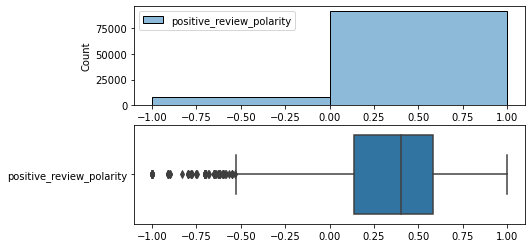

In [38]:
describe_hist_box(train_data, 'positive_review_polarity')

In [39]:
masks_to_try = [
    lambda x: x['positive_review_polarity'] < -0.95,
    lambda x: x['positive_review_polarity'] < -0.85,
    lambda x: x['positive_review_polarity'] < -0.75,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1313
MAPE for mask 1 is 0.1312
MAPE for mask 2 is 0.1313


### Analyzing<br>`review_total_positive_word_counts_alt`

       review_total_positive_word_counts_alt
count                          100000.000000
mean                               16.459610
std                                21.326685
min                                 0.000000
25%                                 4.000000
50%                                10.000000
75%                                21.000000
max                               381.000000


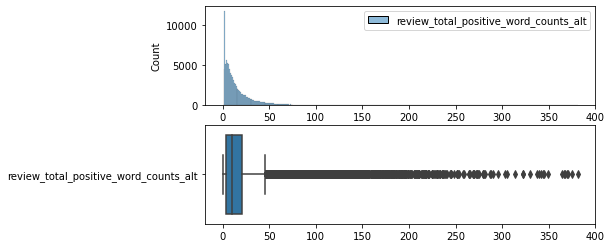

In [40]:
describe_hist_box(train_data, 'review_total_positive_word_counts_alt')

In [41]:
masks_to_try = [
    lambda x: x['review_total_positive_word_counts_alt'] > 150,
    lambda x: x['review_total_positive_word_counts_alt'] > 250,
    lambda x: x['review_total_positive_word_counts_alt'] > 350,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1311
MAPE for mask 1 is 0.1313
MAPE for mask 2 is 0.131


### Analyzing<br>`distance_to_city_center_km`

       distance_to_city_center_km
count               100000.000000
mean                          NaN
std                      0.000000
min                      0.099976
25%                      2.099609
50%                      3.400391
75%                      5.601562
max                     20.406250


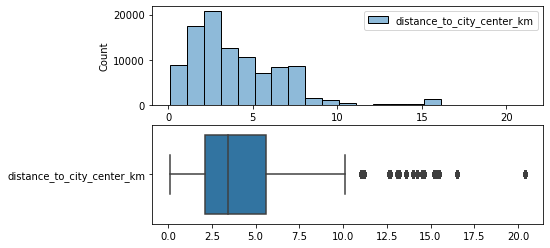

In [42]:
describe_hist_box(train_data, 'distance_to_city_center_km')

In [43]:
masks_to_try = [
    lambda x: x['distance_to_city_center_km'] > 15,
    lambda x: x['distance_to_city_center_km'] > 17,
    lambda x: x['distance_to_city_center_km'] > 19,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1311
MAPE for mask 1 is 0.1311
MAPE for mask 2 is 0.1311


### Analyzing<br>`total_number_of_reviews`

       total_number_of_reviews
count            100000.000000
mean               2750.972460
std                2323.338199
min                  43.000000
25%                1158.000000
50%                2140.000000
75%                3633.000000
max               16670.000000


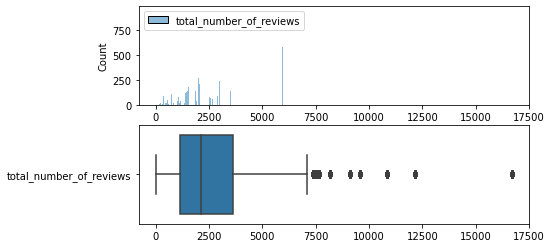

In [44]:
describe_hist_box(train_data, 'total_number_of_reviews')

In [45]:
masks_to_try = [
    lambda x: x['total_number_of_reviews'] > 7500,
    lambda x: x['total_number_of_reviews'] > 10000,
    lambda x: x['total_number_of_reviews'] > 12500,
    lambda x: x['total_number_of_reviews'] > 15000,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1314
MAPE for mask 1 is 0.1313
MAPE for mask 2 is 0.1313
MAPE for mask 3 is 0.1313


### Analyzing<br>`reviewer_score`

       reviewer_score
count   100000.000000
mean         8.403381
std          1.629618
min          2.500000
25%          7.500000
50%          8.800000
75%          9.600000
max         10.000000


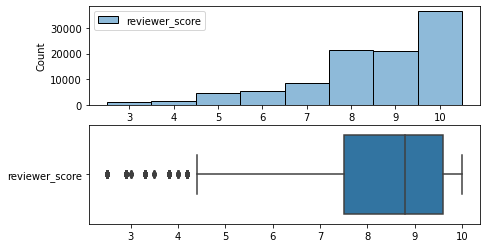

In [46]:
describe_hist_box(train_data, TARGET_COLUMN_NAME)

In [47]:
masks_to_try = [
    lambda x: x[TARGET_COLUMN_NAME] == 2.5,
    lambda x: x[TARGET_COLUMN_NAME] < 3,
    lambda x: x[TARGET_COLUMN_NAME] < 3.5,
    lambda x: x[TARGET_COLUMN_NAME] < 4,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.132
MAPE for mask 1 is 0.1324
MAPE for mask 2 is 0.1335
MAPE for mask 3 is 0.135


We don't see a significant improvement of MAPE on any of tested continous numeric features. We may try to test the `average_score` again but on the full train set this time.

In [48]:
train_data = train_data_before_transform.copy()

y_pred, mape = train_and_estimate(train_data)

print(f'Base MAPE that needs to be improved: {mape}')

Base MAPE that needs to be improved: 0.12939075740448755


In [49]:
masks_to_try = [
    lambda x: x['average_score'] < 5.5,
    lambda x: x['average_score'] < 6,
    lambda x: x['average_score'] < 6.5,
]

test_extremes(train_data, masks_to_try)

MAPE for mask 0 is 0.1294
MAPE for mask 1 is 0.1294
MAPE for mask 2 is 0.1294


We failed to improve the model by excludig the extremve values—none of the action above improved the estimation.

# Improving the model: Most important features

## Selecting number of numeric features 

We will now train the model with different number of numeric columns to see which one gives the best MAPE.

In [50]:
# train_data = get_train_data()
# cleanup_data(train_data, is_train_set=True)
# create_features(train_data, is_train_set=True)

# train_data_before_transform = train_data.copy()



In [51]:
CATEGORICAL_COLUMNS_NUM = 30
N_ESTIMATORS = 5
DEBUG = False

train_data = train_data_before_transform.copy()
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(7, len(NUMERIC_COLUMNS) + 1):
    NUMERIC_COLUMNS_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.1392803033645694 for 7 numeric columns
MAPE 0.13891027624342336 for 8 numeric columns
MAPE 0.1389582482213282 for 9 numeric columns
MAPE 0.1389582482213282 for 10 numeric columns
MAPE 0.13855725912771089 for 11 numeric columns
MAPE 0.1384254998191804 for 12 numeric columns
MAPE 0.13873178141390075 for 13 numeric columns
Best MAPE 0.1384254998191804 achieved with 12 numeric columns


Looks like our best optioin is 12 numeric columns. But we deliberately reduced the number of estimators to speed up the testing. Lets increase it a bit to check how it influences the results.

In [52]:
CATEGORICAL_COLUMNS_NUM = 30
N_ESTIMATORS = 25
DEBUG = False

train_data = train_data_before_transform.copy()
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(7, len(NUMERIC_COLUMNS) + 1):
    NUMERIC_COLUMNS_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.13119780389365285 for 7 numeric columns
MAPE 0.13115909605260334 for 8 numeric columns
MAPE 0.1309642399599092 for 9 numeric columns
MAPE 0.1309642399599092 for 10 numeric columns
MAPE 0.13056990474645644 for 11 numeric columns
MAPE 0.13053161745705488 for 12 numeric columns
MAPE 0.13045852416650278 for 13 numeric columns
Best MAPE 0.13045852416650278 achieved with 13 numeric columns


This time our best choice is 13 numeric columns. It appears that the number of estimators does influence the comparative tests. Lets compare what is the MAPE for 12 and 13 numeric columns with 100 estimators.

In [53]:
CATEGORICAL_COLUMNS_NUM = 30
N_ESTIMATORS = 100
DEBUG = False

train_data = train_data_before_transform.copy()
transform_features(train_data, is_train_set=True)

best_mape = None
best_num = None

for num in range(12, 14):
    NUMERIC_COLUMNS_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    print(f'MAPE {mape} for {num} numeric columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} numeric columns')

MAPE 0.12902440417693659 for 12 numeric columns
MAPE 0.12869144250519723 for 13 numeric columns
Best MAPE 0.12869144250519723 achieved with 13 numeric columns


Due to the results we will use 13 numeric columns.

In [54]:
NUMERIC_COLUMNS_NUM = 13

Lets now test the categorical columns. We will test every third number to speed up the process.

In [57]:
N_ESTIMATORS = 5
DEBUG = False

best_mape = None
best_num = None

train_data = train_data_before_transform.copy()

CATEGORICAL_COLUMNS_BY_IMPORTANCE = get_categorical_columns_by_importance(train_data)

transform_features(train_data, is_train_set=True)
for num in range(20, len(CATEGORICAL_COLUMNS) + 1, 3):
    CATEGORICAL_COLUMNS_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    print(f'MAPE {mape} for {num} categorical columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} categorical columns')

MAPE 0.13909259135882845 for 20 categorical columns
MAPE 0.1391236899372267 for 23 categorical columns
MAPE 0.1392328167408315 for 26 categorical columns
MAPE 0.1390700802148027 for 29 categorical columns
MAPE 0.13896918374074005 for 32 categorical columns
MAPE 0.13892487487151964 for 35 categorical columns
MAPE 0.1387829139566059 for 38 categorical columns
MAPE 0.13887090633238486 for 41 categorical columns
MAPE 0.1385877835500113 for 44 categorical columns
MAPE 0.13884196687940972 for 47 categorical columns
MAPE 0.13882396409773284 for 50 categorical columns
MAPE 0.13858163755064734 for 53 categorical columns
MAPE 0.1385787869691003 for 56 categorical columns
MAPE 0.13862539320898742 for 59 categorical columns
MAPE 0.1386444932917893 for 62 categorical columns
MAPE 0.13858071928786658 for 65 categorical columns
MAPE 0.138420846297751 for 68 categorical columns
MAPE 0.13848261288581493 for 71 categorical columns
MAPE 0.1384319763632067 for 74 categorical columns
MAPE 0.138122869656950

Our best option is 104 categorical columns. Lets increase N_ESTIMATORS and run a few more tests around this number.

In [58]:
N_ESTIMATORS = 25
DEBUG = False

best_mape = None
best_num = None

train_data = train_data_before_transform.copy()

transform_features(train_data, is_train_set=True)
for num in range(101, 107):
    CATEGORICAL_COLUMNS_NUM = num
    y_pred, mape = train_and_estimate(train_data)
    print(f'MAPE {mape} for {num} categorical columns')
    if best_mape is None or best_mape > mape:
        best_mape = mape
        best_num = num

print(f'Best MAPE {best_mape} achieved with {best_num} categorical columns')

MAPE 0.13001832545819517 for 101 categorical columns
MAPE 0.12999033491268253 for 102 categorical columns
MAPE 0.12994344536941646 for 103 categorical columns
MAPE 0.13006836943803118 for 104 categorical columns
MAPE 0.13003548943899695 for 105 categorical columns
MAPE 0.1300317783869907 for 106 categorical columns
Best MAPE 0.12994344536941646 achieved with 103 categorical columns


According to the results our best choice is 103 categorical columns.

In [59]:
CATEGORICAL_COLUMNS_NUM = 103

Lets test again for multicollinearity.

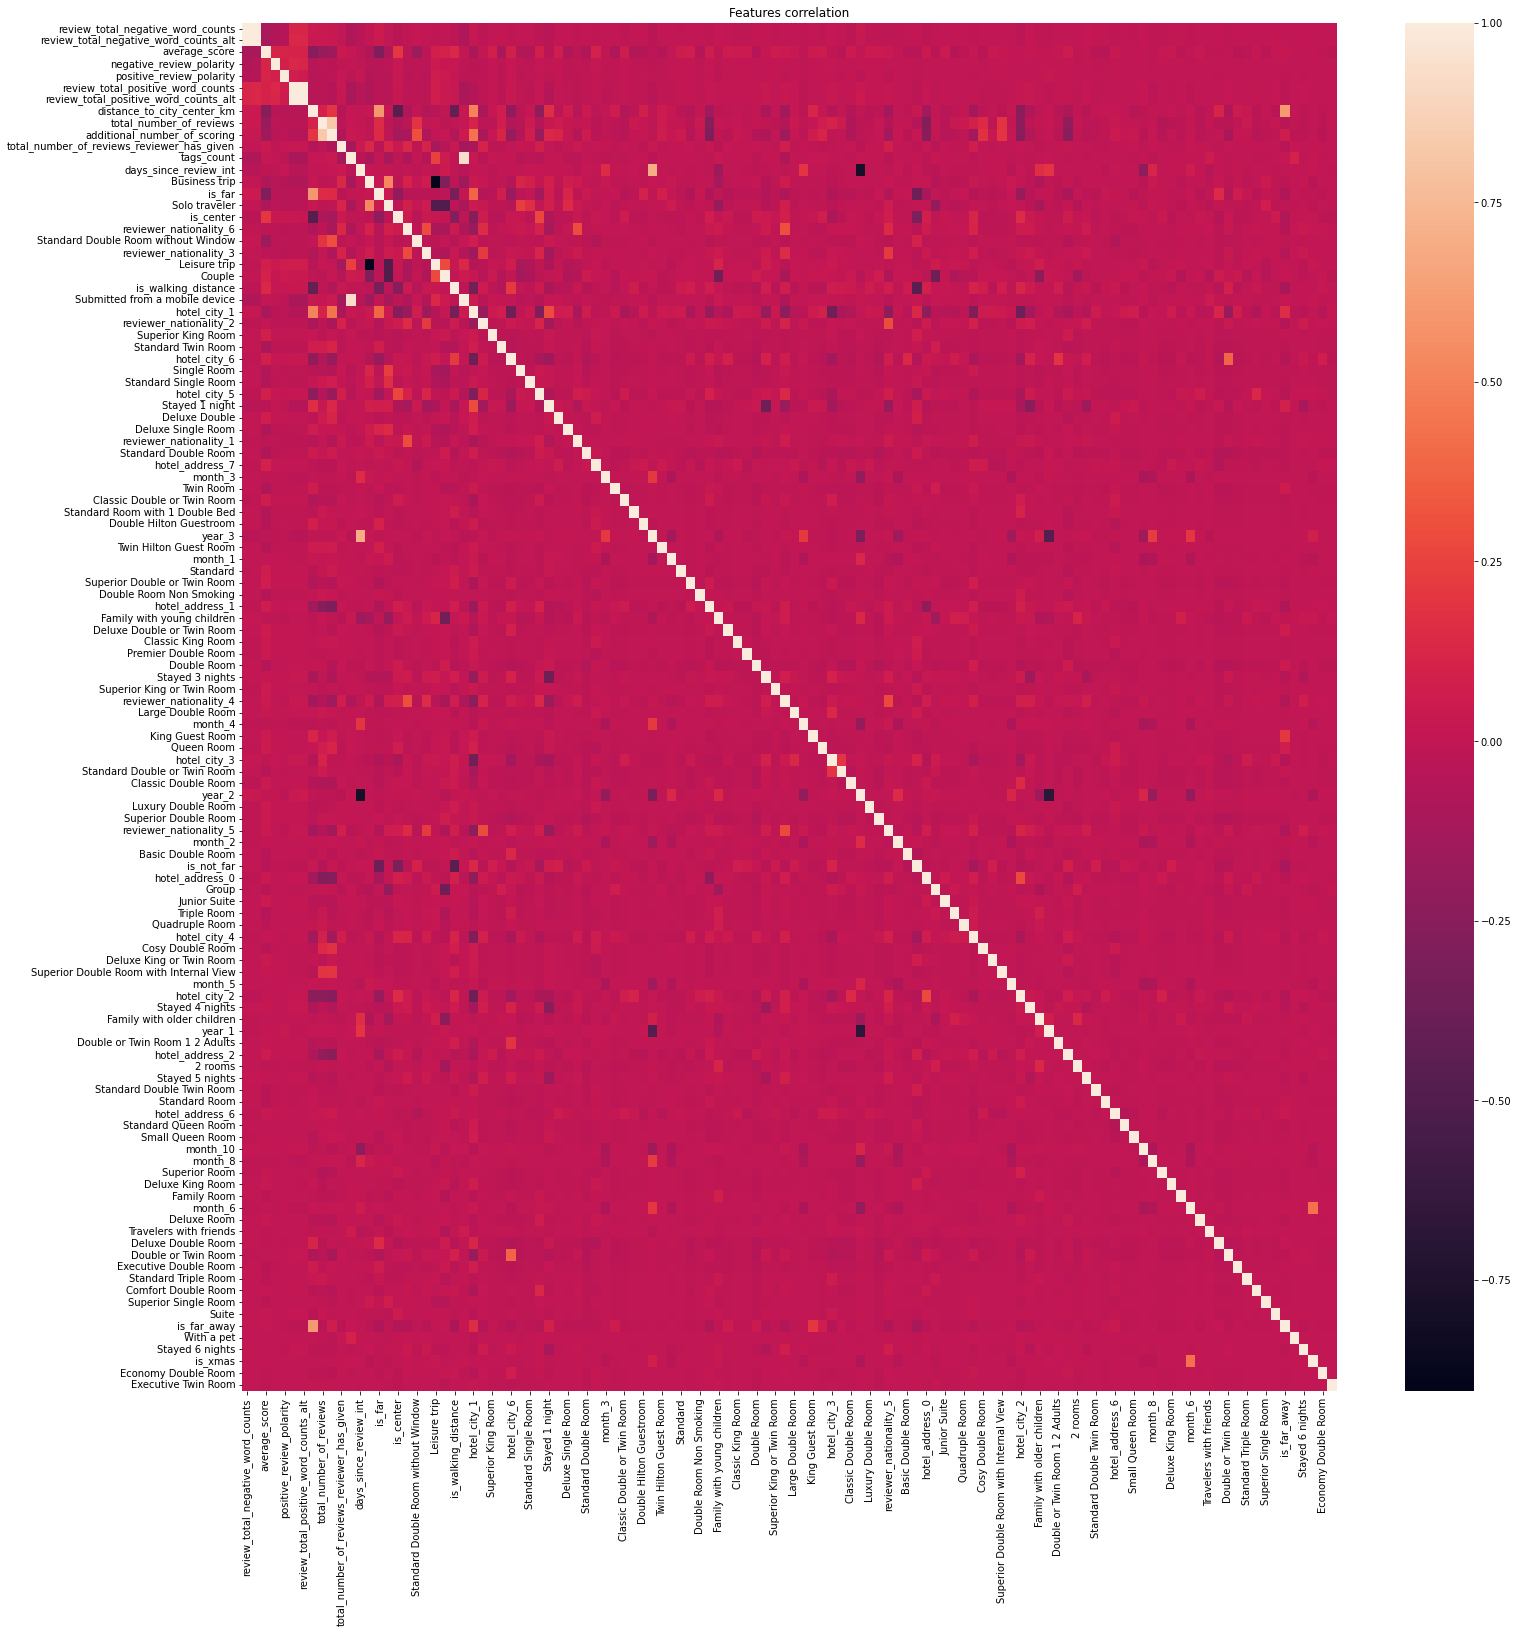

In [60]:
visualize_correlation(train_data, annot=False)

The number of features is too big. We can't use this diagram. Lets rerender it again but only keep columns with high correlation.

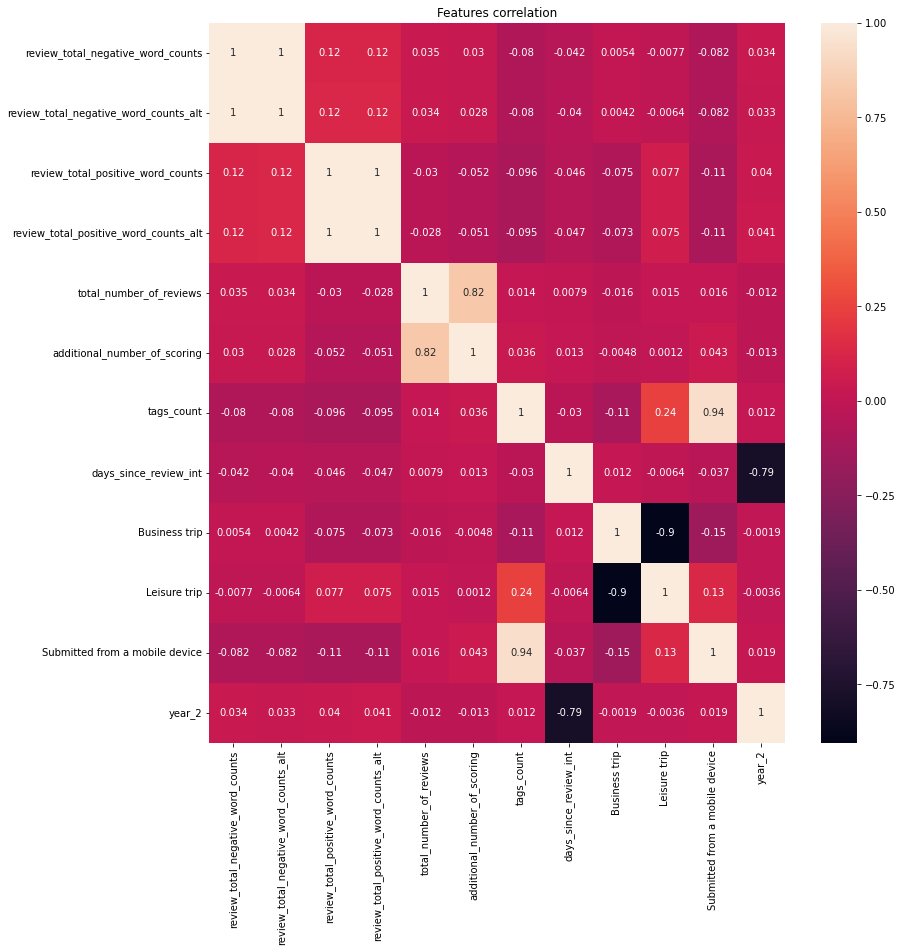

In [61]:
visualize_correlation(train_data, annot=True, all=False)

There are more pairs with high correlation than we saw previously. Lets exclude from training three more columns:
- `Leisure trip`
- `tags_count`
- `days_since_review_int`

In [63]:
EXCLUDE_COLUMNS.extend([
    'Leasure trip',
    'tags_count',
    'days_since_review_int',
])

In [67]:
EXCLUDE_COLUMNS

['review_total_negative_word_counts',
 'review_total_positive_word_counts',
 'additional_number_of_scoring',
 'Leasure trip',
 'tags_count',
 'days_since_review_int']

# Third submission (most important features)

In [68]:
DEBUG = True

# NUMERIC_COLUMNS_NUM = 13
# CATEGORICAL_COLUMNS_NUM = 103
# EXCLUDE_COLUMNS = [
#     'review_total_negative_word_counts',
#     'review_total_positive_word_counts',
#     'additional_number_of_scoring',
#     'Leasure trip',
#     'tags_count',
#     'days_since_review_int']
N_ESTIMATORS = 100

train_data = train_data_before_transform.copy()
transform_features(train_data, is_train_set=True)
y_pred, mape = train_and_estimate(train_data)

print(f'MAPE of model trained on the whole train set: {mape}')

>>> fn. `transform_features` is running
>>> fn. `transform_features__post_cleanup` is running
<<< fn. `transform_features__post_cleanup` finished, took 0 mls

>>> fn. `transform_features__standardize_features` is running
<<< fn. `transform_features__standardize_features` finished, took 102 mls

>>> fn. `transform_features__normalize_features` is running
<<< fn. `transform_features__normalize_features` finished, took 753 mls

<<< fn. `transform_features` finished, took 855 mls

>>> fn. `train_and_estimate` is running
>>> fn. `split_to_train_test` is running
<<< fn. `split_to_train_test` finished, took 590 mls

>>> fn. `train_model` is running
<<< fn. `train_model` finished, took 322.2 s

>>> fn. `estimate_model` is running
>>> fn. `predict` is running
<<< fn. `predict` finished, took 3.8 s

<<< fn. `estimate_model` finished, took 3.8 s

<<< fn. `train_and_estimate` finished, took 326.8 s

MAPE of model trained on the whole train set: 0.12853794281602238


In [69]:
test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
test_data_before_transform = test_data.copy()


>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 820
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 14.3 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 14.4 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       65527
Paris        15098
Barcelona    15017
Amsterdam    14208
Vienna        9761
Milan         9324
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 86 mls

>>> fn. `create_features__add_city_center_lat_lng` is running
<<< fn. `create_features__add_city_center_lat_lng` finished, took 64 mls

>>> fn. `create_features__add_distance_to_city_center` is running
setting `distance_to_city_center_km`
setting `is_center`
setting `is_walking_distance`
setting `is_not

In [70]:
test_data = test_data_before_transform.copy()
transform_features(test_data, is_train_set=False)
y_pred = predict(test_data)

>>> fn. `transform_features` is running
>>> fn. `transform_features__post_cleanup` is running
<<< fn. `transform_features__post_cleanup` finished, took 0 mls

>>> fn. `transform_features__standardize_features` is running
<<< fn. `transform_features__standardize_features` finished, took 16 mls

>>> fn. `transform_features__normalize_features` is running
<<< fn. `transform_features__normalize_features` finished, took 66 mls

<<< fn. `transform_features` finished, took 83 mls

>>> fn. `predict` is running
<<< fn. `predict` finished, took 4.7 s



In [71]:
submission = get_submission_data()
submission[TARGET_COLUMN_NAME] = y_pred
if KAGGLE_ENV:
    submission.to_csv('hotels_prediction_3.csv', index = False)
else:
    submission.to_csv('./data/output/hotels_prediction_3.csv', index = False)

The result is **12.96077** which is a little bit better than the previous one.

To improve MAPE even more lets try to investigate the worst predictions.

# Investigating worst predictions

Lets try to check in what data our model makes the worst predictions. For that we will make a prediction on a part of train data and then compare the predictions with real `reviewer_score` values.

In [72]:
train_data = train_data_before_transform.copy()

X = train_data.drop(columns=[TARGET_COLUMN_NAME])
y = train_data[TARGET_COLUMN_NAME]

# splitting the data to train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# training model wihtout transforming features as we will analyze their initial values
train_model(X_train, y_train)

# Making prediction on the test set with the model trained previously.
# We need to use the test set because the model we have was not trained on this set.
y_pred = predict(X_test)

# Making the data_with_pred dataframe which will contain all the columns
# of the train set and one more column `delta_pred` with difference
# between y_pred and y.
data_with_pred = X_test.copy()
data_with_pred['y'] = y_test
data_with_pred['y_pred'] = predict(X_test)
data_with_pred['delta_pred'] = data_with_pred['y'] - data_with_pred['y_pred']

>>> fn. `train_model` is running
<<< fn. `train_model` finished, took 333.7 s

>>> fn. `predict` is running
<<< fn. `predict` finished, took 4.4 s

>>> fn. `predict` is running
<<< fn. `predict` finished, took 3.4 s



Let's sort the data frame by `delta_pred` and analyze the rows with
the biggest difference.

In [73]:
data_with_pred.sort_values(by='delta_pred', ascending=False, inplace=True)

data_with_pred.head(5)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,y,y_pred,delta_pred
225172,Stadhouderskade 7 Oud West 1054 ES Amsterdam N...,241,1/5/2016,7.7,NH Amsterdam Centre,United Kingdom,No Negative,0,1574,Can t say a bad thing about the hotel,...,0,0,0,0,0,0,1,10.0,4.4490,5.5510
232720,Herrengasse 12 01 Innere Stadt 1010 Vienna Aus...,157,11/12/2015,8.4,Radisson Blu Style Hotel Vienna,Cyprus,I had a very bad experience with a taxi drive...,176,1189,No Positive,...,0,1,0,1,0,0,1,10.0,4.7280,5.2720
262400,23 Leinster Gardens Westminster Borough London...,471,5/18/2017,7.0,Henry VIII,United Kingdom,When we booked it was stated that there was p...,125,2937,Very comfortable clean and tidy Pool and saun...,...,0,0,0,0,0,0,1,10.0,4.9180,5.0820
180826,Leeuwendalersweg 21 Bos en Lommer 1055 JE Amst...,587,6/12/2017,7.4,Best Western Blue Tower Hotel,United Kingdom,Nothjg,2,3869,Everything,...,0,0,0,0,0,0,1,9.6,4.6765,4.9235
349780,5 Olympic Way Wembley Brent London HA9 0NP Uni...,832,3/13/2017,8.9,Novotel London Wembley,United Kingdom,Duvet not large enough bed sheets not tucked ...,100,2924,Bed,...,0,0,0,0,0,0,1,10.0,5.0960,4.9040


It shows us to many features. Lets see only some of them:
- `y`
- `y_pred`
- `delta_pred`
- `average_score`
- `negative_review`
- `negative_review_polarity`
- `positive_review`
- `positive_review_polarity`
- `total_number_of_reviews`
- `distance_to_city_center_km`
- `review_date_dt`


In [74]:
features = [
    'y',
    'y_pred',
    'delta_pred',
    'average_score',
    'negative_review',
    'negative_review_polarity',
    'positive_review',
    'positive_review_polarity',
    'total_number_of_reviews',
    'distance_to_city_center_km',
    'review_date_dt',
]
data_with_pred[features][0:5]

,y,y_pred,delta_pred,average_score,negative_review,negative_review_polarity,positive_review,positive_review_polarity,total_number_of_reviews,distance_to_city_center_km,review_date_dt
225172,10.0,4.4490,5.5510,7.7,No Negative,0.150024,Can t say a bad thing about the hotel,-0.700195,1574,2.900391,2016-01-05
232720,10.0,4.7280,5.2720,8.4,I had a very bad experience with a taxi drive...,-0.066162,No Positive,-0.113647,1189,1.099609,2015-11-12
262400,10.0,4.9180,5.0820,7.0,When we booked it was stated that there was p...,-0.388916,Very comfortable clean and tidy Pool and saun...,0.679199,2937,7.000000,2017-05-18
180826,9.6,4.6765,4.9235,7.4,Nothjg,0.000000,Everything,0.000000,3869,5.800781,2017-06-12
349780,10.0,5.0960,4.9040,8.9,Duvet not large enough bed sheets not tucked ...,-0.109863,Bed,0.000000,2924,15.203125,2017-03-13


Probably there is a mismatch in reviews and their polarity. Lets investigate it better.

## Investigating polarity mismatch

In [75]:
def analyze_row_polarity(row_index):
    row = data_with_pred.loc[row_index]
    print(f'row {row_index}')

    print(f'negative review: "{row["negative_review"]}"')
    print(f'polarity: {row["negative_review_polarity"]}')
    print(f'words: {row["review_total_negative_word_counts_alt"]}')

    print(f'positive review: "{row["positive_review"]}"')
    print(f'polarity: {row["positive_review_polarity"]}')
    print(f'words: {row["review_total_positive_word_counts_alt"]}')
    print('')

analyze_row_polarity(225172)

row 225172
negative review: "No Negative"
polarity: 0.1500244140625
words: 2
positive review: " Can t say a bad thing about the hotel"
polarity: -0.7001953125
words: 9



The polarity for a positive review "Can t say a bad thing about the hotel" is incorrect, it should not be negative.

In [77]:
analyze_row_polarity(180826)

row 180826
negative review: " Nothjg"
polarity: 0.0
words: 1
positive review: " Everything"
polarity: 0.0
words: 1



The positive polarity is zero which is not right. On the other side it is expected for a single word without any context. Maybe we should think of giving some context to the text, e.g. "I liked ...". It would help in this case.

As for the negative review we can try a prefix like "Did I dislike something? ...". Let's test that.

In [78]:
get_polarity = lambda text: TextBlob(text).sentiment.polarity

def test_polarity(text):
    print(f'{get_polarity(text)} for "{text}"')

test_polarity('I liked Everything')
test_polarity('I liked Nothing')
test_polarity('Did I like something? Everything')

test_polarity('Did I dislike something? Nothing')
test_polarity('Did I dislike something? Everything')
test_polarity('Did I like something? Nothing')
test_polarity('Did I like something? Everything')
test_polarity('Bed things: nothing')

0.6 for "I liked Everything"
0.6 for "I liked Nothing"
0.0 for "Did I like something? Everything"
0.0 for "Did I dislike something? Nothing"
0.0 for "Did I dislike something? Everything"
0.0 for "Did I like something? Nothing"
0.0 for "Did I like something? Everything"
0.0 for "Bed things: nothing"


Apparently our tests don't show good results. Maybe we should try some other library to analyze guest comments.
Let's try NLTK, [here is an example of using it](https://www.nltk.org/howto/sentiment.html), which seems to be fitting our needs.

## Trying NLTK

In [79]:
# ! pip install nltk

In [80]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [81]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ev/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
def test_polarity2(text):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)
    print(text)
    print(ss)

In [84]:
test_polarity2('Can t say a bad thing about the hotel')

test_polarity2('I liked Everything')
test_polarity2('I liked Nothing')

test_polarity2('Did I dislike something? Nothing')
test_polarity2('Did I dislike something? Everything')

test_polarity2('Did I like something? Nothing')
test_polarity2('Did I like something? Everything')

test_polarity2('Bed things: everything')
test_polarity2('Bed things: nothing')

Can t say a bad thing about the hotel
{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'compound': -0.5423}
I liked Everything
{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
I liked Nothing
{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}
Did I dislike something? Nothing
{'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.3818}
Did I dislike something? Everything
{'neg': 0.464, 'neu': 0.536, 'pos': 0.0, 'compound': -0.3818}
Did I like something? Nothing
{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
Did I like something? Everything
{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}
Bed things: everything
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bed things: nothing
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Unfortunately **nlkt** does not see any difference between "nothing" and "everything" regardless whatever context we give. It also gives a negative compound value for "Can t say a bad thing about the hotel".

The good thing is **nltk** estimates negative and positive sentiment separately. We can use this ability.

Lets rework `create_features__add_review_polarity` and make another submission.

In [91]:
@logger
def create_features__add_review_polarity(data):
    get_negative_polarity = lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['neg']
    get_positive_polarity = lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['pos']

    data.loc[:, 'negative_review_polarity'] = data['negative_review'].apply(get_negative_polarity)
    data['negative_review_polarity'] = np.float16(data['negative_review_polarity'])

    data.loc[:, 'positive_review_polarity'] = data['positive_review'].apply(get_positive_polarity)
    data['positive_review_polarity'] = np.float16(data['positive_review_polarity'])


In [102]:
DEBUG = True

NUMERIC_COLUMNS_NUM = 13
CATEGORICAL_COLUMNS_NUM = 103
EXCLUDE_COLUMNS = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'additional_number_of_scoring',
    'Leasure trip',
    'tags_count',
    'days_since_review_int']
N_ESTIMATORS = 100

train_data = get_train_data()
cleanup_data(train_data, is_train_set=True)
create_features(train_data, is_train_set=True)

NUMERIC_COLUMNS_BY_IMPORTANCE = get_numeric_columns_by_importance(train_data)
CATEGORICAL_COLUMNS_BY_IMPORTANCE = get_categorical_columns_by_importance(train_data)

train_data_before_transform = train_data.copy()

transform_features(train_data, is_train_set=True)
y_pred, mape = train_and_estimate(train_data)

print(f'MAPE of model trained on the whole train set: {mape}')

>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__remove_duplicates` is running
removed 307 duplicated rows
<<< fn. `cleanup_data__remove_duplicates` finished, took 1.2 s

>>> fn. `cleanup_data__remove_anomalies` is running
<<< fn. `cleanup_data__remove_anomalies` finished, took 0 mls

>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 2448
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 37.7 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 39.3 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       196773
Barcelona     45132
Paris         44528
Amsterdam     43004
Vienna        29177
Milan         27882
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 265 mls

>>> fn. `create_features__add_city_c



It means that to improve the model results we may need to use some custom parser for short comments.

Let's see what are the most common comments without polarity.

In [103]:
test_data = get_test_data()
cleanup_data(test_data, is_train_set=False)
create_features(test_data, is_train_set=False)
test_data_before_transform = test_data.copy()


>>> fn. `cleanup_data` is running
>>> fn. `cleanup_data__add_missing_coords` is running
Entries with missing lat/lng before: 820
Entries with missing lat/lng after: 0
<<< fn. `cleanup_data__add_missing_coords` finished, took 13.0 s

>>> fn. `cleanup_data__remove_useless_features` is running
<<< fn. `cleanup_data__remove_useless_features` finished, took 0 mls

<<< fn. `cleanup_data` finished, took 13.1 s

>>> fn. `create_features` is running
>>> fn. `create_features__add_city` is running
London       65527
Paris        15098
Barcelona    15017
Amsterdam    14208
Vienna        9761
Milan         9324
Name: hotel_city, dtype: int64
<<< fn. `create_features__add_city` finished, took 86 mls

>>> fn. `create_features__add_city_center_lat_lng` is running
<<< fn. `create_features__add_city_center_lat_lng` finished, took 71 mls

>>> fn. `create_features__add_distance_to_city_center` is running
setting `distance_to_city_center_km`
setting `is_center`
setting `is_walking_distance`
setting `is_not

In [104]:
test_data = test_data_before_transform.copy()
transform_features(test_data, is_train_set=False)
y_pred = predict(test_data)

>>> fn. `transform_features` is running
>>> fn. `transform_features__post_cleanup` is running
<<< fn. `transform_features__post_cleanup` finished, took 0 mls

>>> fn. `transform_features__standardize_features` is running
<<< fn. `transform_features__standardize_features` finished, took 19 mls

>>> fn. `transform_features__normalize_features` is running
<<< fn. `transform_features__normalize_features` finished, took 121 mls

<<< fn. `transform_features` finished, took 141 mls

>>> fn. `predict` is running
<<< fn. `predict` finished, took 5.0 s



In [105]:
submission = get_submission_data()
submission[TARGET_COLUMN_NAME] = y_pred
if KAGGLE_ENV:
    submission.to_csv('hotels_prediction_4.csv', index = False)
else:
    submission.to_csv('./data/output/hotels_prediction_4.csv', index = False)



It improved MAPE for a tiny bit, the new result it **12.92287** (was 12.96077).

# Вывод

Мы выполнили полный цикл (почти) разработки модели:
- получили данные и поставленную задачу
- очистили данные
- создали новые признаки
- выбрали самые важные признаки
- сделали трансформацию данных
- обучили модель
- оценили результаты и попытались их улучшить

Мы ближе познакомились с платформой Kaggle, приняли участие в соревновании. Нам удалось достичь удовлетворительных результатов. К сожалению, победить в соревновании не получилось, но это было трудная и ресурсоемкая задача. На работу ушла уйма времени (человеческого и машинного). Хочется надеяться, что приобретенный опыт не пропадет даром.